# **A Data-Driven Comparative Analysis of Disability-Adjusted Life Years (DALYs) and Socioeconomic Development Indicators**
## Exploring the Impact of Economic, Educational, and Demographic Factors on Global Health Burden


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


##### **Research Question 1**: Is there a significant correlation between GDP per capita and total DALYs across countries?
##### **Hypothesis** Higher GDP per capita is associated with lower total DALYs.

In [3]:
# Extract GDP per capita data for 2021
worldbank_df = pd.read_csv('dataset/worldbank-datasets-2021.csv')
gdp_per_capita_2021 = worldbank_df[worldbank_df.iloc[:, 0] == "GDP per capita (current US$)"]

# Extract DALYs rate data for 2021
dalys_df = pd.read_csv('dataset/IMHE-GBD-ALL-DALYs-per100k-1990-2021.csv')
dalys_rate_2021 = dalys_df[dalys_df['year'] == 2021]

# Extract population data for 2021
population_df = pd.read_csv('dataset/2021_population.csv')

In [5]:
# Prepare GDP data properly
gdp_df = gdp_per_capita_2021.copy()
# The World Bank data structure: [Indicator, Country, Country Code, Value]
gdp_df.columns = ['indicator', 'country', 'country_code', 'gdp_per_capita']
gdp_df = gdp_df[['country', 'gdp_per_capita']].copy()
gdp_df = gdp_df[gdp_df['gdp_per_capita'].notna()]
# Convert to numeric, replacing '..' with NaN
gdp_df['gdp_per_capita'] = pd.to_numeric(gdp_df['gdp_per_capita'], errors='coerce')
gdp_df = gdp_df.dropna()

# Prepare DALY data
dalys_clean = dalys_rate_2021[['location_name', 'val']].copy()
dalys_clean.columns = ['country', 'dalys_rate']
dalys_clean = dalys_clean[dalys_clean['dalys_rate'].notna()]

# Prepare population data
pop_df = population_df[['country', '2021_last_updated']].copy()
pop_df.columns = ['country', 'population']
pop_df = pop_df[pop_df['population'].notna()]
# Convert population to numeric
pop_df['population'] = pd.to_numeric(pop_df['population'].astype(str).str.replace(',', ''), errors='coerce')
pop_df = pop_df.dropna()

In [6]:
# Check data before merging
print("GDP data shape:", gdp_df.shape)
print("DALY data shape:", dalys_clean.shape)
print("Population data shape:", pop_df.shape)

GDP data shape: (258, 2)
DALY data shape: (204, 2)
Population data shape: (224, 2)


In [7]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df, on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
if len(df1) > 0:
    df1.head()
else:
    print("No matching countries found. Check country name formats.")

DataFrame shape: (158, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 158


In [8]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')

# Rename columns for clarity
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
df1.head()

DataFrame shape: (158, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 158


,countries,dalys_rate_2021,gdp_per_capita_2021,population_2021
0,Afghanistan,54970.40051,356.496214,40374668
1,Albania,34816.53755,6413.282808,2869700
2,Algeria,28024.94386,4160.559267,45061896
3,American Samoa,34224.30229,15236.160490,55100
4,Andorra,27497.83696,42425.699680,77355


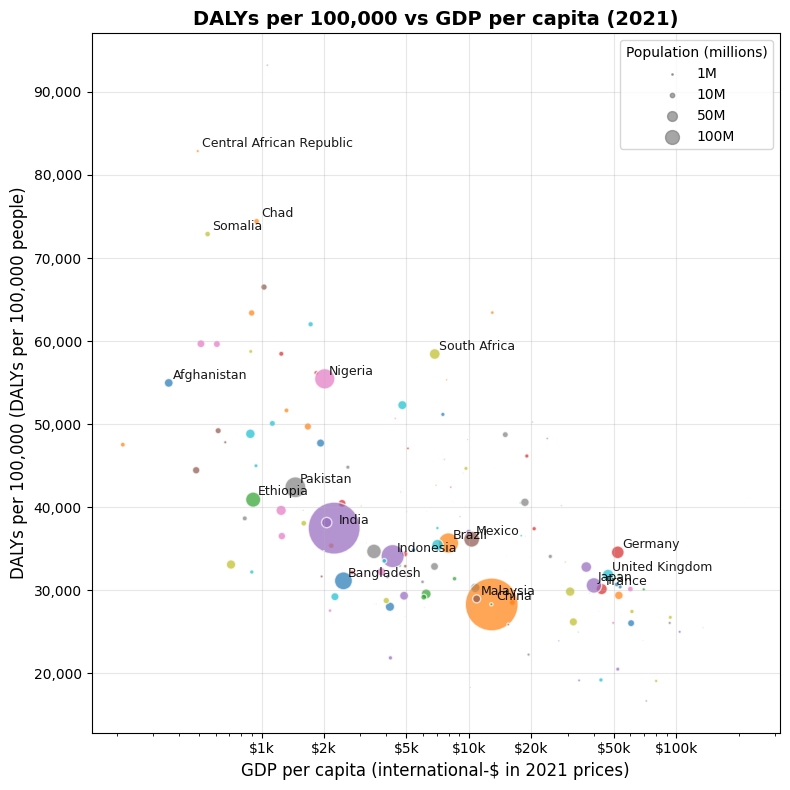


Dataset Statistics:
Number of countries: 158
GDP per capita range: $214 - $223823
DALYs rate range: 16685 - 93225


In [20]:
# Create bubble plot for GDP per capita vs DALYs per 100k using matplotlib
plt.figure(figsize=(8, 8))

# Create the scatter plot with bubble sizes
scatter = plt.scatter(df1['gdp_per_capita_2021'], 
                     df1['dalys_rate_2021'],
                     s=df1['population_2021']/1000000,  # Scale population for bubble size
                     alpha=0.7,
                     c=range(len(df1)),
                     cmap='tab10',
                     edgecolors='white',
                     linewidth=1)

plt.xscale('log')

# Set custom x-axis ticks and labels
x_ticks = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
x_labels = ['$1k', '$2k', '$5k', '$10k', '$20k', '$50k', '$100k']
plt.xticks(x_ticks, x_labels)

# Format y-axis with whole numbers
from matplotlib.ticker import FuncFormatter

def whole_number_formatter(x, pos):
    return f'{x:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(whole_number_formatter))

# Labels and title
plt.xlabel('GDP per capita (international-$ in 2021 prices)', fontsize=12)
plt.ylabel('DALYs per 100,000 (DALYs per 100,000 people)', fontsize=12)
plt.title('DALYs per 100,000 vs GDP per capita (2021)', fontsize=14, fontweight='bold')

# Add grid
plt.grid(True, alpha=0.3)

# Define major/relevant countries to label
major_countries = ['United States', 'China', 'India', 'Germany', 'Japan', 'United Kingdom', 
                  'France', 'Brazil', 'Russia', 'South Africa', 'Nigeria', 'Ethiopia',
                  'Bangladesh', 'Pakistan', 'Malaysia', 'Indonesia', 'Mexico', 'Turkey', 'Iran',
                  'Afghanistan', 'Central African Republic', 'Chad', 'Somalia']

# Label only major/relevant countries
for i, country in enumerate(df1['countries']):
    if country in major_countries:
        plt.annotate(country, 
                    (df1['gdp_per_capita_2021'].iloc[i], df1['dalys_rate_2021'].iloc[i]),
                    xytext=(3, 3), 
                    textcoords='offset points', 
                    fontsize=9, 
                    alpha=0.9)

# Add legend for bubble sizes
sizes = [1, 10, 50, 100]  # Example population sizes in millions
labels = ['1M', '10M', '50M', '100M']
legend_bubbles = []
for size in sizes:
    legend_bubbles.append(plt.scatter([], [], s=size, alpha=0.7, color='gray'))

plt.legend(legend_bubbles, labels, scatterpoints=1, loc='upper right', 
          title='Population (millions)', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# Display basic statistics
print(f"\nDataset Statistics:")
print(f"Number of countries: {len(df1)}")
print(f"GDP per capita range: ${df1['gdp_per_capita_2021'].min():.0f} - ${df1['gdp_per_capita_2021'].max():.0f}")
print(f"DALYs rate range: {df1['dalys_rate_2021'].min():.0f} - {df1['dalys_rate_2021'].max():.0f}")

In [21]:
print("=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher GDP per capita is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5589
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.3567
Pearson p-value: 0.000004
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Weak negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k
✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)


##### **Research Question 2**: How does the Human Development Index (HDI) relate to DALYs.?
##### **Hypothesis** Higher HDI is associated with lower total DALYs.

In [23]:
development_df = pd.read_csv('dataset/2021_development.csv')
hdi_2021 = development_df[['Country', 'Human Development Index (HDI) - 2021']].copy()

# Prepare HDI data properly
hdi_df = hdi_2021.copy()
hdi_df.columns = ['country', 'hdi']
hdi_df = hdi_df[hdi_df['hdi'].notna()]
# Convert to numeric
hdi_df['hdi'] = pd.to_numeric(hdi_df['hdi'], errors='coerce')
hdi_df = hdi_df.dropna()

print("HDI data shape:", hdi_df.shape)
print(hdi_df.head())

HDI data shape: (191, 2)
       country    hdi
0  Switzerland  0.962
1       Norway  0.961
2      Iceland  0.959
3    Hong Kong  0.952
4    Australia  0.951


In [24]:
# Create new df
df2 = dalys_clean.merge(hdi_df, on='country', how='inner')
print(f"DataFrame shape after merging with HDI: {df2.shape}")
print(df2.head())

DataFrame shape after merging with HDI: (179, 3)
       country   dalys_rate    hdi
0  Afghanistan  54970.40051  0.478
1      Albania  34816.53755  0.796
2      Algeria  28024.94386  0.745
3      Andorra  27497.83696  0.858
4       Angola  47727.66851  0.586


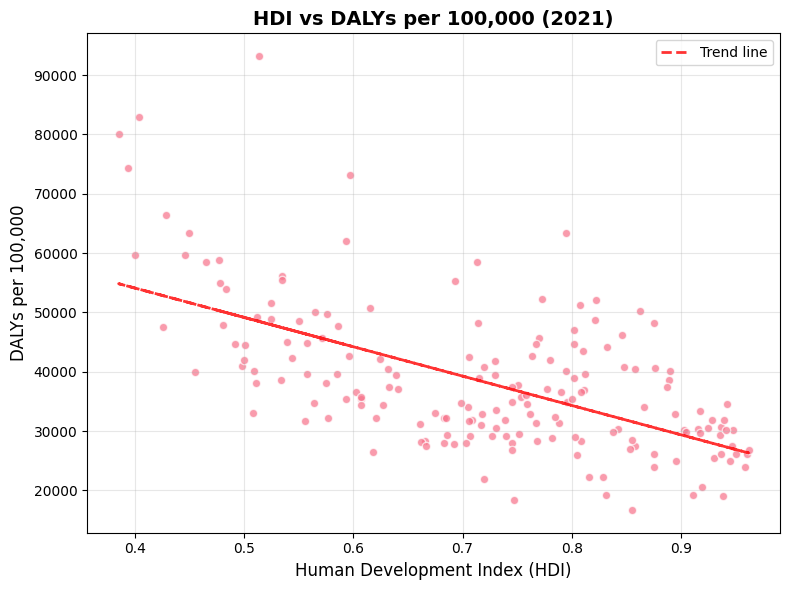

In [28]:
# Create scatter plot for HDI vs DALYs per 100k

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df2['hdi'], df2['dalys_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Human Development Index (HDI)', fontsize=12)
plt.ylabel('DALYs per 100,000', fontsize=12)
plt.title('HDI vs DALYs per 100,000 (2021)', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(df2['hdi'], df2['dalys_rate'], 1)
p = np.poly1d(z)
plt.plot(df2['hdi'], p(df2['hdi']), "r--", alpha=0.8, linewidth=2, label='Trend line')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows a **negative correlation** between the Human Development Index (HDI) and Disability-Adjusted Life Years (DALYs) per 100,000 people for the year 2021. 

### Observations:
1. **Trend Line**:
   - The red dashed trend line indicates that as HDI increases, DALYs per 100,000 tend to decrease.
   - This supports the hypothesis that higher socioeconomic development (as measured by HDI) is associated with better health outcomes and lower disease burden.

2. **Data Distribution**:
   - Countries with lower HDI (below 0.6) generally have higher DALYs, often exceeding 50,000 per 100,000 people.
   - Countries with higher HDI (above 0.8) tend to have lower DALYs, typically below 30,000 per 100,000 people.

3. **Outliers**:
   - There are a few outliers with very high DALYs despite moderate HDI values (e.g., HDI around 0.5–0.6). These could represent countries facing unique health challenges or crises.

### Conclusion:
The graph visually confirms a **negative relationship** between HDI and DALYs, suggesting that improving HDI may lead to reduced health burdens globally. Further statistical analysis can quantify the strength of this relationship.

In [29]:
print("=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df2['hdi'], df2['dalys_rate'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df2['hdi'], df2['dalys_rate'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between HDI and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher HDI is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5580
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.5998
Pearson p-value: 0.000000
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Moderate negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between HDI and DALYs per 100k
✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)
